### Libraries

In [1]:
#Essentials
import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from torch.nn import functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, ConcatDataset, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from umap import UMAP

#User libraries
from BatchEffectDataLoader import DataPreprocess, DataTransform, ABaCoDataLoader
from BatchEffectCorrection import correctCombat
from BatchEffectPlots import plotPCA, plotPCoA
from BatchEffectMetrics import kBET, iLISI, cLISI, ARI, ASW
from ABaCo import ABaCo, BatchDiscriminator, TissueClassifier, DataDiscriminator
from MetaABaCo import NormalPrior, NormalEncoder, ZINBDecoder, VAE, train

>> clustergrammer2 backend version 0.18.0


### Data loading

In [86]:
input_size = 3326
d_z = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Data from MGnify - Only DTU entries
file = "metadataset_w_study_dataset_all_biomes_merged_abund_tables_genus.csv"
path = f"data/MGnify/datasets/{file}"

batch_label = "instrument_platform"
exp_label = "biomes"
drop_cols = ["experiment_type", "study_id", "centre_name", "index"]

raw_data = DataPreprocess(path, factors = ["sample", batch_label, exp_label]).dropna().reset_index(drop=True) #drop samples without meta info
pre_data = raw_data[raw_data["centre_name"]=="DTU-GE"].reset_index(drop=True)
new_data = pre_data.drop(drop_cols, axis=1)
new_data[exp_label] = new_data[exp_label].str.replace("root:Engineered:", "", regex=False) #remove redundant label

#exclude batches that can't be corrected
data = new_data
data = new_data[new_data[exp_label] != "Wastewater"]

otu_dataloader, ohe_batch, ohe_biome, otu_data, otu_batch, otu_biome = ABaCoDataLoader(data, 
                                                                                       device = device, 
                                                                                       batch_label=batch_label, 
                                                                                       exp_label=exp_label, 
                                                                                       batch_size = 145, 
                                                                                       total_size = 3326, 
                                                                                       total_batch=2)

#plot PCA of data to visualize it
plotPCoA(data, method="aitchison", sample_label="sample", batch_label=batch_label, experiment_label=exp_label)

### Separate Data for initial training of simple VAE

In [3]:
for x, _, _ in otu_dataloader:
    vae_dataloader = DataLoader(TensorDataset(x[:,:-2]), batch_size = 145)

In [4]:
for x in vae_dataloader:
    print(x)

[tensor([[  5., 457.,   4.,  ...,   0.,   0.,   0.],
        [  1.,  11.,   0.,  ...,   0.,   0.,   0.],
        [  4.,  53.,   1.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.]], device='cuda:0')]


### Defining the VAE networks

In [87]:
# Prior
prior = NormalPrior(d_z)

# Encoder
normal_encoder_net = nn.Sequential(
    nn.Linear(input_size, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 258),
    nn.ReLU(),
    nn.Linear(258, 2*d_z)
)

# Decoder
zinb_decoder_net = nn.Sequential(
    nn.Linear(d_z, 258),
    nn.ReLU(),
    nn.Linear(258, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 3*input_size)
)

# Defining VAE model
encoder = NormalEncoder(normal_encoder_net)
decoder = ZINBDecoder(zinb_decoder_net)
model = VAE(prior, encoder, decoder).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


### Training loop

In [89]:
epochs = 10000

train(model, optimizer, vae_dataloader, epochs, device)

Training: 100%|██████████| 10000/10000 [01:28<00:00, 113.04it/s, epoch=10000/10000, loss=1040.5347]


### Forward pass of trained model

In [90]:
recon_data = []

for x in vae_dataloader:
    x = x[0].to(device)
    recon_data.append(model(x).sample().tolist())

### Visualization of the Aitchison distances among reconstructed samples

In [91]:
recon_data = np.array(recon_data).reshape(-1, np.array(recon_data).shape[-1])

otu_corrected_pd = pd.concat([pd.DataFrame(recon_data, index = otu_data.index, columns = otu_data.columns),
                          otu_batch,
                          otu_biome,
                          data["sample"]],
                          axis=1)

plotPCoA(otu_corrected_pd, method="aitchison", sample_label="sample", batch_label=batch_label, experiment_label=exp_label)

### Latent space visualization

In [108]:
latent_space = []
for x in vae_dataloader:
    x = x[0].to(device)
    q = model.encoder(x)
    z = q.rsample()
    latent_space.append(z.tolist())
    
latent_space = np.array(latent_space).reshape(-1, np.array(latent_space).shape[-1])

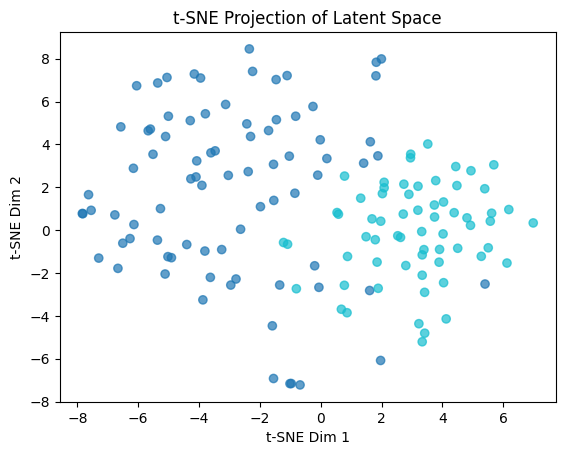

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume latent_vectors is your latent space representation (N samples × D dimensions)
batch_info = np.argmax(np.array(ohe_batch.tolist()), axis=1)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(latent_space)

plt.scatter(reduced[:, 0], reduced[:, 1], c = batch_info, cmap="tab10", alpha=0.7)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.title("t-SNE Projection of Latent Space")
plt.show()